In [1]:
#Use darfixplay as the environment
%matplotlib ipympl

import sys
import os
import cv2
import numpy as np
from skimage.filters import gaussian as gaussian_filter_skimage
import torch
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

sys.path.append(r'/zhome/a7/7/183900/Thesis/CellTracking/PMP')
sys.path.append(r'/zhome/a7/7/183900/Thesis/CellTracking/DataAnalysis/Classes')


from DFXM.scan_functions import *
from DFXM.image_processor import inv_polefigure_colors 
from util_2D import *

In [3]:
path = r'/dtu/3d-imaging-center/projects/2022_QIM_PMP/analysis/Johann_Haack/Data/Data_Small_Steps'
img_size = [1790,1847]

#This does not crop and not register the images
Img_phi_array, Img_chi_array,Img_phi_array_cropped,Img_chi_array_cropped,order= load_2D_time_data(path,img_size, 'COM')
print(order)
Img_list = np.squeeze([ np.sqrt(Img_phi_array**2 + Img_chi_array**2)])
Img_list_cropped = np.squeeze([ np.sqrt(Img_phi_array_cropped**2 + Img_chi_array_cropped**2)])

Skipping Img_phi at index 2 due to insufficient size: (2048, 2048)
Skipping Img_chi at index 3 due to insufficient size: (2048, 2048)
Skipping Img_phi at index 3 due to insufficient size: (2048, 2048)
Skipping Img_chi at index 6 due to insufficient size: (2048, 2048)
Skipping Img_chi at index 7 due to insufficient size: (2048, 2048)
Skipping Img_phi at index 8 due to insufficient size: (2048, 2048)
['67_3_chi_COM.edf', '66_3_chi_COM.edf', '67_6_chi_COM.edf', '64_chi_COM.edf', '66_2_chi_COM.edf', '65_2_chi_COM.edf', '63_chi_COM.edf', '65_0_chi_COM.edf', '67_5_chi_COM.edf', '67_2_chi_COM.edf', '66_1_chi_COM.edf', '67_1_chi_COM.edf', '66_0_chi_COM.edf', '67_4_chi_COM.edf']


In [2]:
film_2D(Img_chi_array)

NameError: name 'Img_chi_array' is not defined

<h3> Registration of the Movie of 2D images </h3>

[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]
[ True]


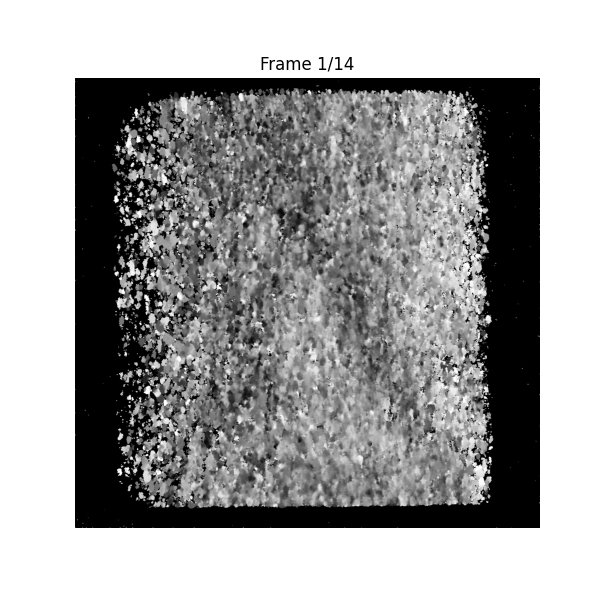

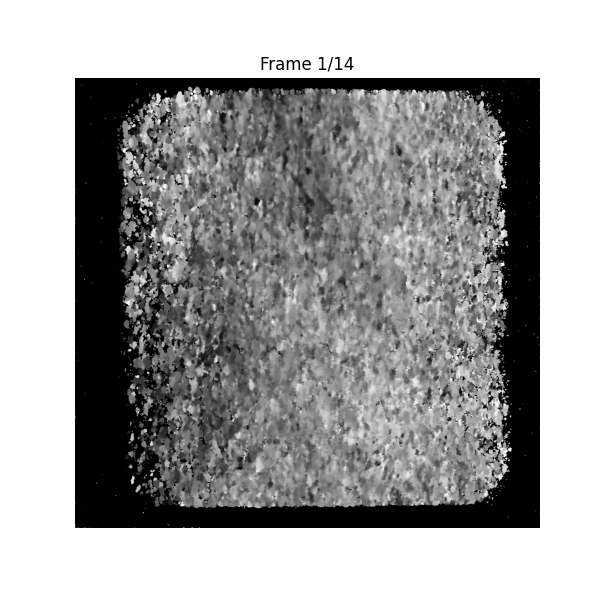

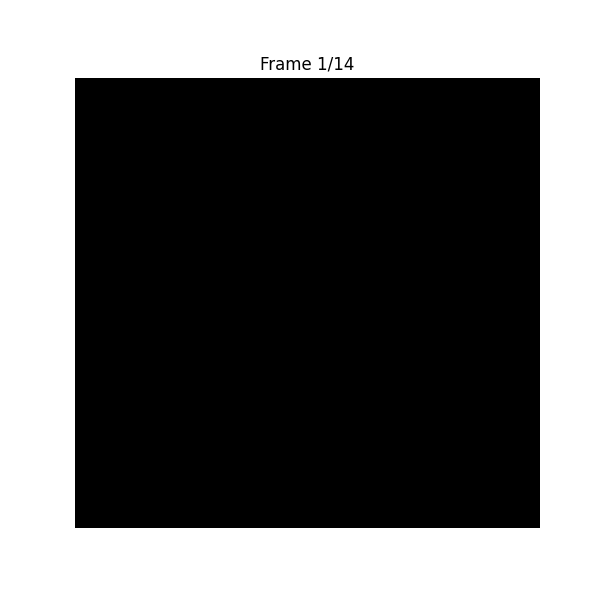

In [9]:
def crop_array(array, target_rows, target_cols):
    current_rows, current_cols = array.shape
    row_start = (current_rows - target_rows) // 2
    col_start = (current_cols - target_cols) // 2
    return array[int(row_start*1.5): target_rows+int(1.5*row_start), col_start:col_start + target_cols]

#Step 1 load and crop them to one size => the cropping shoud be ok as we have quite a big boarder
com_phi, com_chi = load_data(path, 'COM')
fwhm_phi, fwhm_chi = load_data(path, 'FWHM')
com_phi_list, com_chi_list = [],[]
com_chi_row_list, com_chi_col_list = [],[]
grain_mask_list = []

for i in range(len(com_chi)):
    Img_chi, maximum_chi, minimum_chi, average_chi, TF_chi, row_size_chi, col_size_chi, _ = process_data(path, com_chi[i], method='COM')
    Img_phi, maximum_phi, minimum_phi, _, _, _, _, _ = process_data(path, com_phi[i], method='COM')
    #This grain mask is only for nan values what if i put a snake on the picutes for a proper mask
    grain = find_grain(TF_chi)
    _, _, grain_mask = values_histogram(Img_chi, maximum_chi, grain)
    print(np.unique(grain_mask))

    grain_mask_list.append(grain_mask)
    com_chi_list.append(Img_chi)
    com_phi_list.append(Img_phi)
    com_chi_row_list.append(img_size[0])
    com_chi_col_list.append(img_size[1])


#It is the same for chi and phi
row_min_com= max(com_chi_row_list)
col_min_com = max(com_chi_col_list)

# Crop all arrays to the minimum size and plot
cropped_chi = np.array([crop_array(img, row_min_com, col_min_com) for img in com_chi_list])
film_2D(cropped_chi)
cropped_phi = np.array([crop_array(img, row_min_com, col_min_com) for img in com_phi_list])
film_2D(cropped_phi)
cropped_mask = np.array([crop_array(img, row_min_com, col_min_com) for img in grain_mask_list])
film_2D(cropped_mask)


In [13]:
def determine_warp_matrix(reference_image, moving_image, mask):
    # Apply Gaussian filter to smooth both images, in ECC we already have this on default but double will not hurt any
    moving_gaussian = gaussian_filter_skimage(moving_image, sigma=5)
    
    reference_norm_image = reference_image.astype(np.float32)
    moving_norm_image = moving_gaussian.astype(np.float32)

    # Initialize the warp matrix for rigid (Euclidean) transformation
    warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define criteria for ECC
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000, 1e-6)

    # Perform ECC registration using the norm images
    try:
        cc, warp_matrix = cv2.findTransformECC(reference_norm_image, moving_norm_image, warp_matrix, cv2.MOTION_TRANSLATION, criteria, inputMask=mask)
    except cv2.error as e:
        print(f"ECC registration failed: {e}")
        return moving_image  # Return original image if registration fails



    return warp_matrix

def move_image(reference_image, moving_image,warp_matrix):
    aligned_image = cv2.warpAffine(moving_image, warp_matrix, (reference_image.shape[1], reference_image.shape[0]),
                                   flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return aligned_image

# Example usage
reference_image = cropped_chi[4]  # Use the 2D image at index 4 as the reference
reference_gaussian = gaussian_filter_skimage(reference_image, sigma=5)

#create mask
# Create a mask with all zeros (same size as the original image)
mask = np.zeros_like(reference_image, dtype=np.uint8)
mask[300:1500, 700:1500] = 1

# Align each 2D image in 'cropped_chi' to the reference
aligned_images_chi,aligned_images_phi = [],[]
for i in range(len(cropped_chi)):
    if i == 3:
        aligned_images_chi.append(reference_image)  # Append the reference image itself
        aligned_images_phi.append(cropped_phi[7])
        continue

    warp_matrix = determine_warp_matrix(reference_gaussian, cropped_chi[i],mask)

    aligned_image_chi = move_image(reference_image, cropped_chi[i],warp_matrix)
    aligned_image_phi = move_image(reference_image, cropped_phi[i],warp_matrix)
    aligned_images_chi.append(aligned_image_chi)
    aligned_images_phi.append(aligned_image_phi)

# Convert the list of aligned images into a NumPy array
aligned_images_array_chi = np.array(aligned_images_chi)
aligned_images_array_phi = np.array(aligned_images_phi)



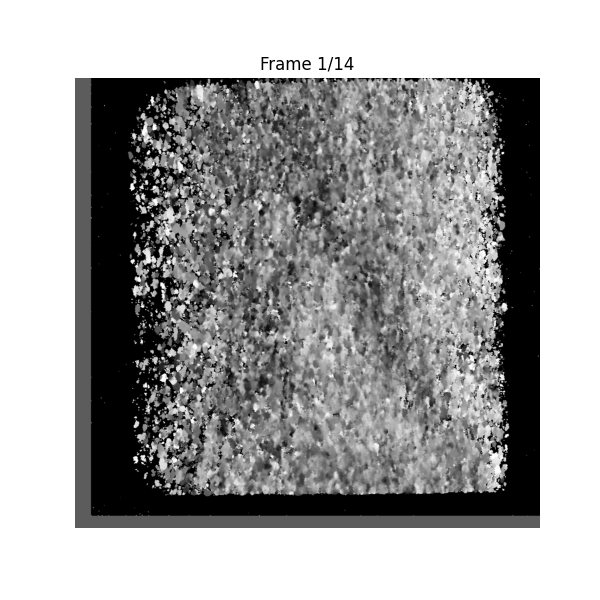

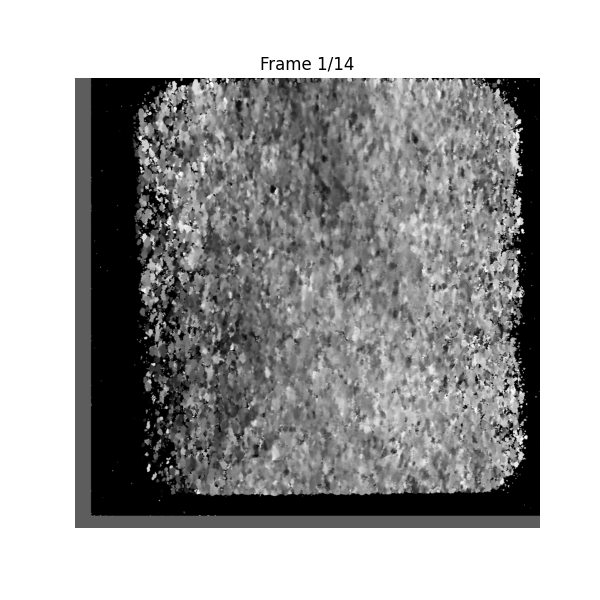

In [14]:
film_2D(aligned_images_array_chi)
film_2D(aligned_images_array_phi)

In [7]:
# Load SAM model (the 'vit_b' version is lighter but still powerful
sam_checkpoint = r'/zhome/a7/7/183900/Thesis/CellTracking/Weights/sam_vit_b_01ec64.pth'
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device='cuda' if torch.cuda.is_available() else 'cpu')

predictor = SamPredictor(sam)

masks_lst = []
for i in range(aligned_images_array_chi.shape[0]):
    # Assuming your image is grayscale, convert to 3-channel (RGB) by repeating it
    image_8bit = cv2.normalize(aligned_images_array_chi[i], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
    image_rgb = cv2.cvtColor(image_8bit, cv2.COLOR_GRAY2RGB)    
    predictor.set_image(image_rgb)
    
    # You can specify a point in the image for mask extraction if needed
    input_point = np.array([[1000, 1000]])  # Example point (Y, X)
    input_label = np.array([1])  # Label for foreground (1 for object)
    
    masks, _, _ = predictor.predict(point_coords=input_point, point_labels=input_label)
    
    # The predicted mask for the current image slice
    current_mask = masks[0]
    
    # Append the mask for this image to the list
    masks_lst.append(current_mask)

# Convert the list of masks into a NumPy array
masks_array = np.array(masks_lst)


c:\Users\JohannHaack\miniconda3\envs\ThesisEnv\lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


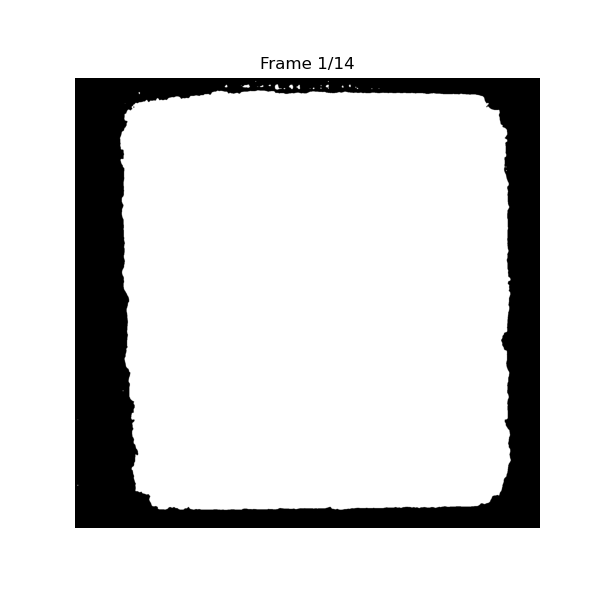

In [8]:
film_2D(masks_array)

<h3> KAM filter on the Registered Film</h3>

In [9]:
skel_KAM_list, skel_KAM_dilated_list = [],[]

for i in range(len(aligned_images_array_chi)):

    col_size = aligned_images_array_chi[i].shape[0]
    row_size = aligned_images_array_chi[i].shape[1]

    KAM = calculate_KAM(col_size, row_size, masks_array[i], aligned_images_array_chi[i], aligned_images_array_phi[i], 2)

    KAM_mask, skel_KAM = KAM_refine(KAM, cropped_mask[i])

    skel_KAM_dilated = binary_dilation(skel_KAM, disk(1))

    skel_KAM_list.append(skel_KAM)
    skel_KAM_dilated_list.append(skel_KAM_dilated)

skel_KAM_array = np.array(skel_KAM_list)
skel_KAM_dilated_array = np.array(skel_KAM_dilated_list)


(1790, 1847)
KAM mask: percentage in walls 74.46% with KAM threshold: 0.002
KAM mask: percentage in walls 74.46% with KAM threshold: 0.0022
KAM mask: percentage in walls 74.46% with KAM threshold: 0.0024000000000000002
KAM mask: percentage in walls 74.45% with KAM threshold: 0.0026000000000000003
KAM mask: percentage in walls 74.45% with KAM threshold: 0.0028000000000000004
KAM mask: percentage in walls 74.45% with KAM threshold: 0.0030000000000000005
KAM mask: percentage in walls 74.44% with KAM threshold: 0.0032000000000000006
KAM mask: percentage in walls 74.44% with KAM threshold: 0.0034000000000000007
KAM mask: percentage in walls 74.43% with KAM threshold: 0.0036000000000000008
KAM mask: percentage in walls 74.43% with KAM threshold: 0.003800000000000001
KAM mask: percentage in walls 74.43% with KAM threshold: 0.004000000000000001
KAM mask: percentage in walls 74.42% with KAM threshold: 0.004200000000000001
KAM mask: percentage in walls 74.42% with KAM threshold: 0.00440000000000

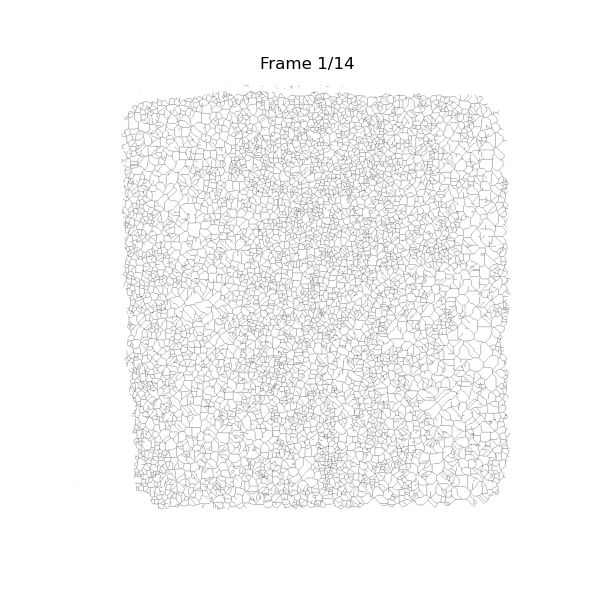

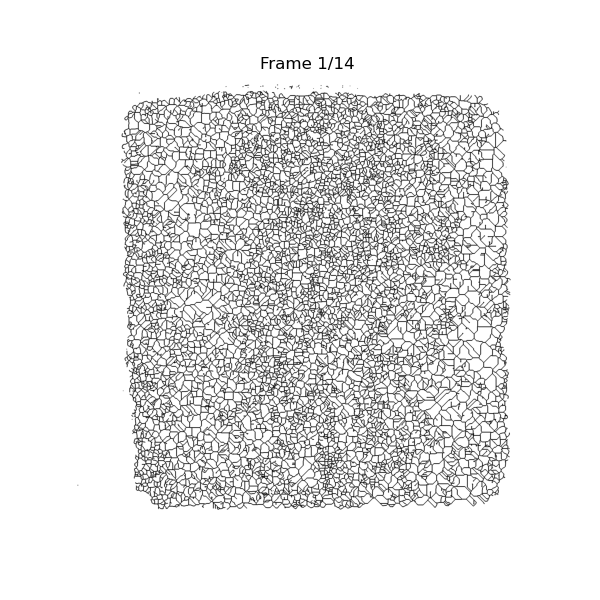

In [10]:
film_2D(1-skel_KAM_array)
film_2D(1-skel_KAM_dilated_array)

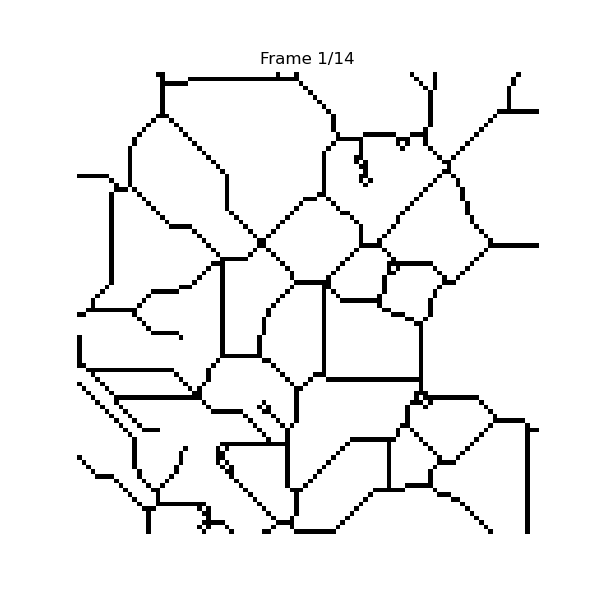

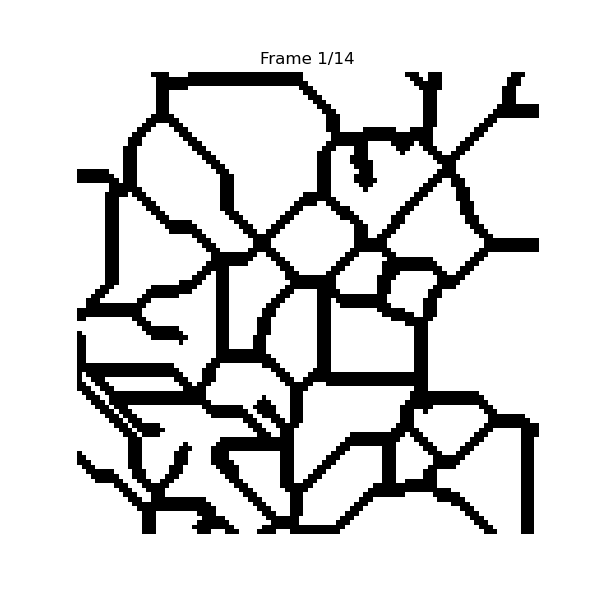

In [11]:
#Lets looked at the cropped KAM cells
skel_KAM_array_cropped = np.array([crop_array(img, 100, 100) for img in skel_KAM_list])
skel_KAM_dilated_array_cropped = np.array([crop_array(img, 100, 100) for img in skel_KAM_dilated_list])
film_2D(1-skel_KAM_array_cropped)
film_2D(1-skel_KAM_dilated_array_cropped)

In [ ]:
#Now lets define the once of certain size as cells, than do binary on the boundaries and non cell and onl yleave the inner of the cells than we can run the connected components on the binary images in 3D